# EDA
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.
* The patient demographic data such as gender, age.
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 

In [1]:
import os
from glob import glob
from skimage import io
from itertools import chain
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')

# build a dataframe that has 50% pneumonia cases
df1 = sample_df.loc[sample_df['Finding Labels'].str.contains('Pneumonia')].reset_index()[18:26]
df2 = sample_df.loc[sample_df['Finding Labels'].str.contains('No Finding')][:8]
df3 = pd.concat([df1, df2], axis=0)

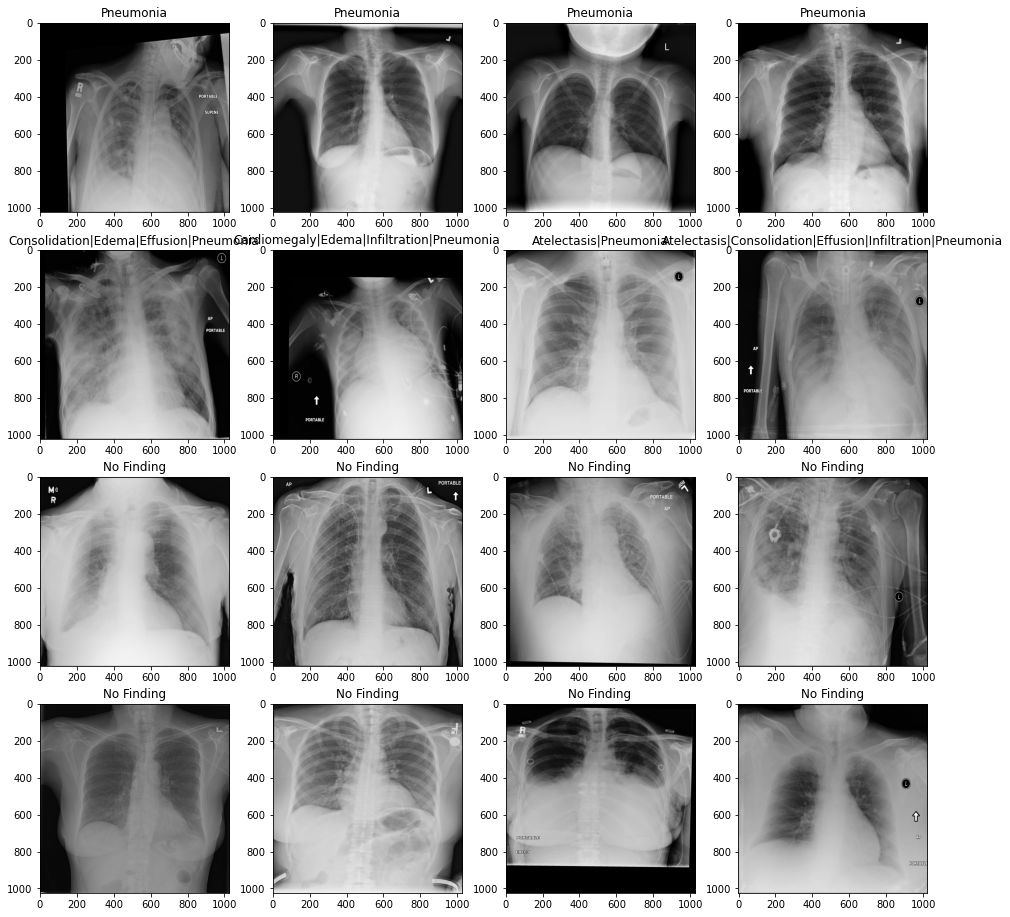

In [3]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

# Visualize medical images 
fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = df3['Image Index']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(image_paths[img])
    ax.imshow(img,cmap='gray')
    ax.set_title(df3.iloc[ind]['Finding Labels'])
    ind=ind+1

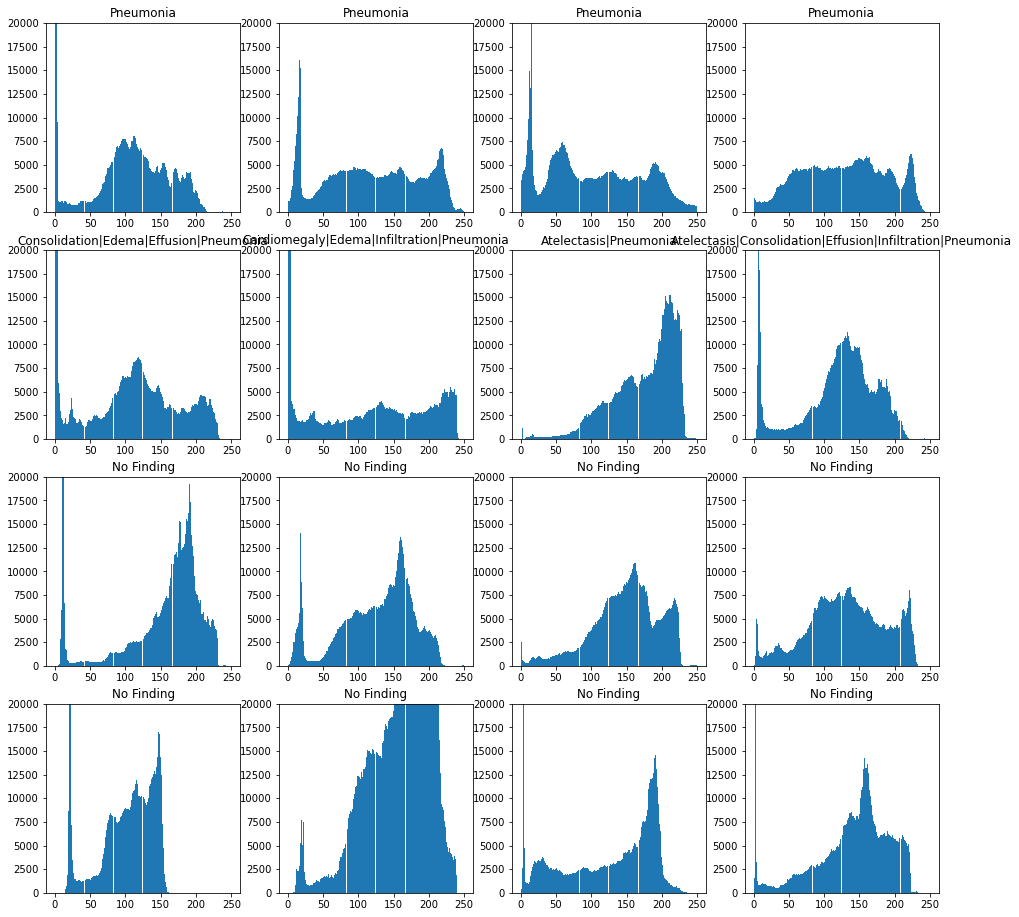

In [4]:
# visualize intensity distributions of images with different disease labels
# for normal lungs, there is usually a peak at around 150 
# pneumonia together with comorbidities could exhibit a different intensity profile compared to pneumonia without comorbidities
# however, they are both different from the intensity profiles with no findings and can be used in trainings

fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = df3['Image Index'][-16:]
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(image_paths[img])
    ax.hist(img.ravel(), bins = 256, range=(0, 250));
    ax.set_ylim(0, 20000)
    ax.set_title(df3.iloc[ind]['Finding Labels'])
    ind += 1

In [5]:
# Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

# Create paths for each image
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['Path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [6]:
# OneHotCode the finding labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df['Class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Pneumonia' if x==1 else "Non-pneumonia")
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Class
9835,00002547_003.png,No Finding,3,2547,62,F,PA,2936,2948,0.143,...,0,0,0,0,1,0,0,0,0,Non-pneumonia
84542,00020811_004.png,Atelectasis|Effusion|Infiltration|Pleural_Thic...,4,20811,29,M,PA,2992,2991,0.143,...,0,0,1,0,0,0,1,0,0,Non-pneumonia
63410,00015647_020.png,No Finding,20,15647,45,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,Non-pneumonia


In [7]:
# examine data types and null values
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Path                         112120 non-null  object 
 13 

In [8]:
# examine the statistics
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN,0.103095,0.024759,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN,0.304084,0.155391,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# drop the Unnamed: 11 column
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

In [10]:
# fix the column names
all_xray_df.columns = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y' , 'Path', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema','Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia','Pneumothorax', 'Class']

In [11]:
# examine and fix the data error in Patient Age
print(all_xray_df['Patient Age'].sort_values(ascending=False)[:20])
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 120]

46965     414
86264     413
91369     412
20852     412
85404     412
84810     411
104590    155
101194    155
98495     154
95794     153
74884     152
78795     151
58650     150
62929     149
55742     148
48284     148
58464      95
578        94
74736      94
74735      94
Name: Patient Age, dtype: int64


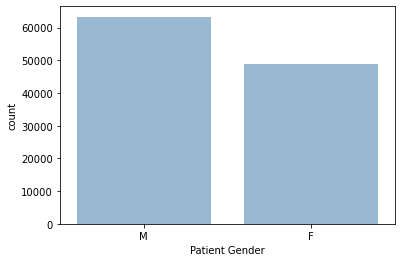

In [12]:
# gender distribution for the entire population
# the number of man is 20% more than the number of women in the population
base_color = sns.color_palette()[0]
sns.countplot(data = all_xray_df, x = 'Patient Gender', color=base_color, alpha=0.5);

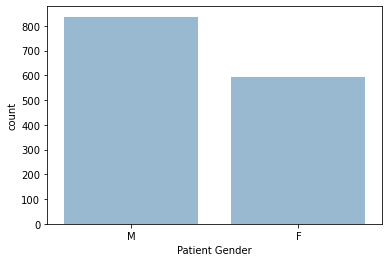

In [13]:
# gender distribution for pneumonia patients
# the number of man is 33% more than the number of women in the population
sns.countplot(data = all_xray_df.loc[all_xray_df.Pneumonia==1], x = 'Patient Gender', color=base_color, alpha=0.5);   

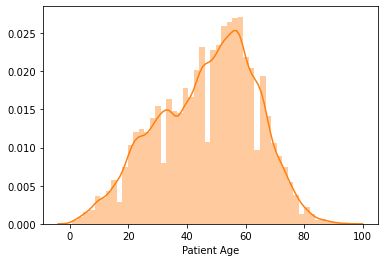

In [14]:
# age distribution for the entire population
# patient age peaks at about 60
base_color = sns.color_palette()[1]
sns.distplot(all_xray_df['Patient Age'], color=base_color);

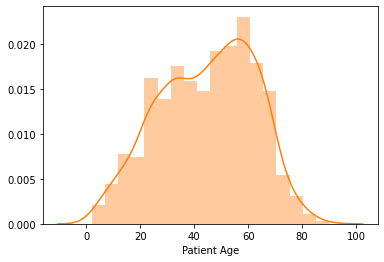

In [15]:
# age distribution for pneumonia patients
# patient age peaks at about 60
sns.distplot(all_xray_df.loc[all_xray_df.Pneumonia==1, 'Patient Age'], color=base_color);

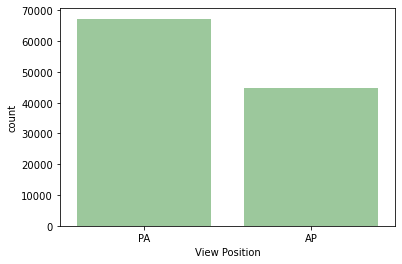

In [16]:
# view position distribution for the entire population
base_color = sns.color_palette()[2]
sns.countplot(data = all_xray_df, x = 'View Position', color=base_color, alpha=0.5);

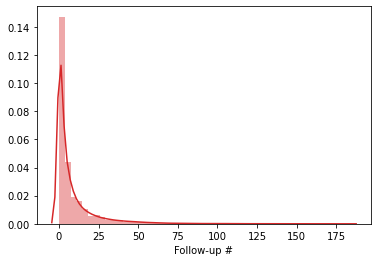

In [17]:
# follow-up number distribution for the entire population
base_color = sns.color_palette()[3]
sns.distplot(all_xray_df['Follow-up #'], color=base_color);

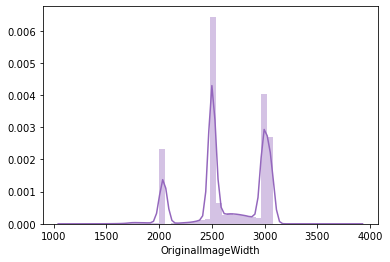

In [18]:
# image width distribution for the entire population 
base_color = sns.color_palette()[4]
sns.distplot(all_xray_df['OriginalImageWidth'], color=base_color);

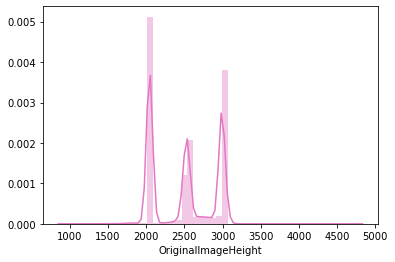

In [19]:
# image height distribution for the entire population
base_color = sns.color_palette()[6]
sns.distplot(all_xray_df['OriginalImageHeight'], color=base_color);

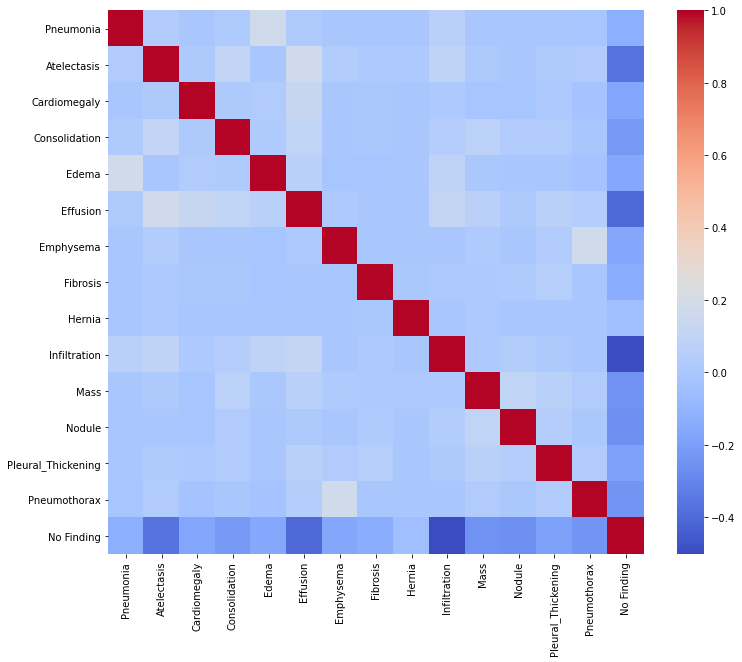

In [20]:
# correlation between pneumonia and other diseases
# pneumonia has a relatively high correlation with Edema and Infiltration
plt.figure(figsize=(12,10))
comorbid = ['Pneumonia', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax', 'No Finding', 'Class']
label_df = all_xray_df[comorbid]
corr_df = label_df.corr() 
sns.heatmap(corr_df, cmap='coolwarm')

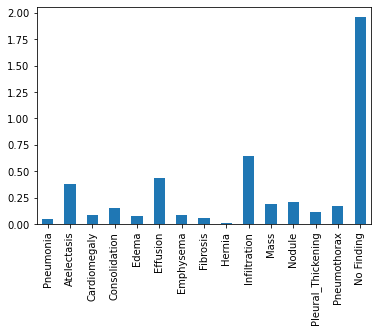

In [21]:
# disease number per patient
(label_df.drop(columns=['Class']).sum() / all_xray_df['Patient ID'].nunique()).plot.bar();

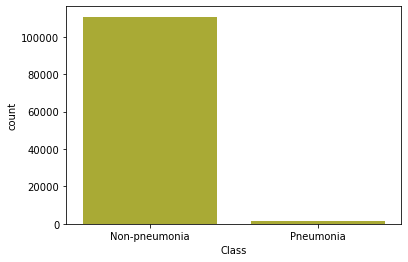

In [22]:
# the population has a small percentage of pneumonia patients 
# which needs to be addressed when spliting the train and test samples
base_color = sns.color_palette()[8]
sns.countplot(data = label_df, x = 'Class', color = base_color);

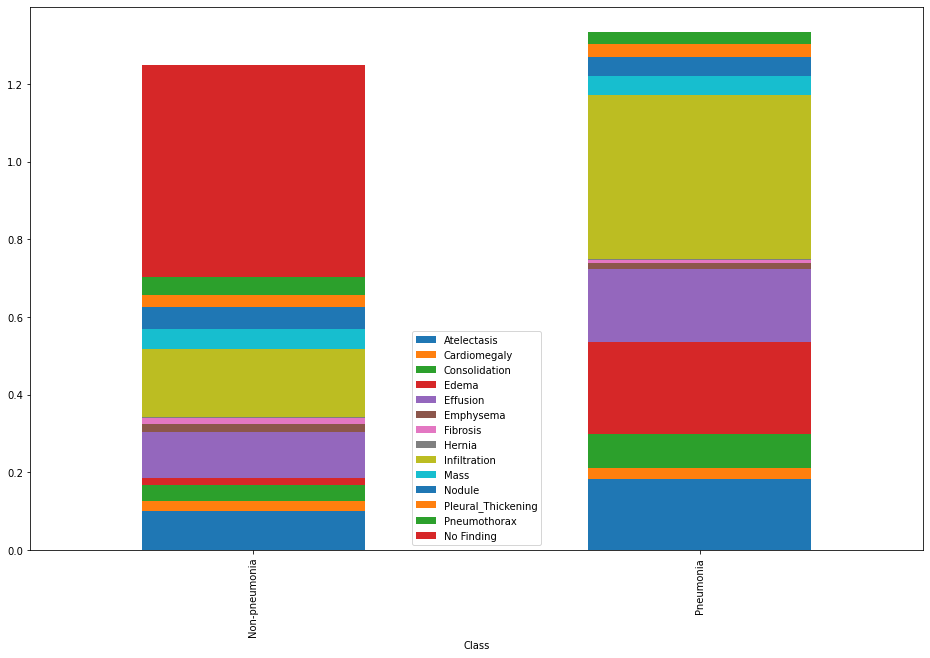

In [23]:
# Pneumonia patients are likely to have edema and infiltration as comorbidities
group = label_df.groupby('Class')[[x for x in comorbid if x != 'Pneumonia']].mean()
group.plot.bar(stacked=True, figsize=(16, 10));
plt.legend(loc=0)

In [24]:
all_xray_df.to_csv('Data_Entry_2017_updated.csv', index=False)